## 1. Subscribe to the model package

To subscribe to the model package:
1. Open the model package listing page [Medical VLM - 24B](https://aws.amazon.com/marketplace/pp/prodview-sagwxj5hcox4o)
1. On the AWS Marketplace listing, click on the **Continue to subscribe** button.
1. On the **Subscribe to this software** page, review and click on **"Accept Offer"** if you and your organization agrees with EULA, pricing, and support terms. 
1. Once you click on **Continue to configuration button** and then choose a **region**, you will see a **Product Arn** displayed. This is the model package ARN that you need to specify while creating a deployable model using Boto3. Copy the ARN corresponding to your region and specify the same in the following cell.

**Model**: `JSL-Medical-VLM-24B`  
**Model Description**: Medical LLM tailored for efficient clinical summarization, question answering, and retrieval-augmented generation (RAG). Delivers high-quality, context-aware responses while balancing performance and cost—ideal for healthcare institutions seeking accurate medical analysis without heavy compute requirements.

In [1]:
model_package_arn = "<Customer to specify Model package ARN corresponding to their AWS region>"

In [ ]:
import os
import base64
import json
import uuid
import io
import requests
from IPython.display import display
from IPython.display import Image, display
from PIL import Image as PILImage
from sagemaker import ModelPackage
import sagemaker as sage
from sagemaker import get_execution_role
import boto3
import numpy as np
import pandas as pd

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

sagemaker_session = sage.Session()
s3_bucket = sagemaker_session.default_bucket()
region = sagemaker_session.boto_region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")
role = get_execution_role()

sagemaker = boto3.client("sagemaker")
s3_client = sagemaker_session.boto_session.client("s3")
ecr = boto3.client("ecr")
sm_runtime = boto3.client("sagemaker-runtime")

In [3]:
model_name = "JSL-Medical-VLM-24B"

real_time_inference_instance_type = "ml.g5.48xlarge"
batch_transform_inference_instance_type = "ml.g5.48xlarge"

## 2. Create a deployable model from the model package.

In [4]:
model = ModelPackage(
    role=role, 
    model_package_arn=model_package_arn, 
    sagemaker_session=sagemaker_session, 
)

## Model Configuration Documentation  

### Default Configuration  
The container comes with the following default configurations:  

| Parameter               | Default Value               | Description                                                                 |
|-------------------------|-----------------------------|-----------------------------------------------------------------------------|
| **`host`**              | `0.0.0.0`                   | Host name                                                                   |
| **`port`**              | `8080`                      | Port number                                                                 |
| **`tensor_parallel_size`** | Auto                    | Automatically set to the number of available GPUs                          |
| **`tokenizer_mode`**    | `mistral`                   | Tokenizer mode compatible with Mistral-based models                         |
| **`config_format`**     | `mistral`                   | Configuration format for model loading                                     |
| **`load_format`**       | `mistral`                   | Model checkpoint format (e.g., HuggingFace, mistral)                        |

### Hardcoded Settings  
The following settings are hardcoded in the container and cannot be changed:  

| Parameter       | Value           | Description                           |  
|-----------------|-----------------|---------------------------------------|  
| **`model`**     | `/opt/ml/model` | Model path where SageMaker mounts the model |  

### Configurable Environment Variables  
You can customize the vLLM server by setting environment variables when creating the model.  

**Any parameter from the [vLLM documentation](https://docs.vllm.ai/en/latest/serving/openai_compatible_server.html#vllm-serve) can be set using the corresponding environment variable with the `SM_VLLM_` prefix.**  

The container uses a script similar to the [SageMaker entrypoint example](https://docs.vllm.ai/en/latest/examples/sagemaker_entrypoint.html) from the vLLM documentation to convert environment variables to command-line arguments.  

---  

## Input Format  

### 1. Chat Completion  

#### Example Payload  
```json  
{  
    "model": "/opt/ml/model",  
    "messages": [  
        {"role": "system", "content": "You are a helpful medical assistant."},  
        {"role": "user", "content": "What should I do if I have a fever and body aches?"}  
    ],  
    "max_tokens": 1024,  
    "temperature": 0.7  
}  
```  

For additional parameters:  
- [ChatCompletionRequest](https://github.com/vllm-project/vllm/blob/v0.8.5/vllm/entrypoints/openai/protocol.py#L232)  
- [OpenAI's Chat API](https://platform.openai.com/docs/api-reference/chat/create)  

---  

### 2. Text Completion  

#### Single Prompt Example  
```json  
{  
    "model": "/opt/ml/model",  
    "prompt": "How can I maintain good kidney health?",  
    "max_tokens": 512,  
    "temperature": 0.6  
}  
```  

#### Multiple Prompts Example  
```json  
{  
    "model": "/opt/ml/model",  
    "prompt": [  
        "How can I maintain good kidney health?",  
        "What are the best practices for kidney care?"  
    ],  
    "max_tokens": 512,  
    "temperature": 0.6  
}  
```  

Reference:  
- [CompletionRequest](https://github.com/vllm-project/vllm/blob/v0.8.5/vllm/entrypoints/openai/protocol.py#L730)  
- [OpenAI's Completions API](https://platform.openai.com/docs/api-reference/completions/create)  

---  

### 3. Image + Text Inference

The model supports both online (direct URL) and offline (base64-encoded) image inputs.

#### Online Image Example
```json
{
    "model": "/opt/ml/model",
    "messages": [
        {"role": "system", "content": "You are a helpful medical assistant."},
        {
            "role": "user",
            "content": [
                {"type": "text", "text": "What does this medical image show?"},
                {"type": "image_url", "image_url": {"url": "https://example.com/image.jpg"}}
            ]
        }
    ],
    "max_tokens": 2048,
    "temperature": 0.15
}
```

#### Offline Image Example (Base64)
```json
{
    "model": "/opt/ml/model",
    "messages": [
        {"role": "system", "content": "You are a helpful medical assistant."},
        {
            "role": "user",
            "content": [
                {"type": "text", "text": "What does this medical image show?"},
                {"type": "image_url", "image_url": {"url": "data:image/jpeg;base64,..."}}
            ]
        }
    ],
    "max_tokens": 2048,
    "temperature": 0.15
}
```

Reference:
- [vLLM Vision Language Models Documentation](https://docs.vllm.ai/en/v0.6.2/models/vlm.html)

---  

### Important Notes:
- **Streaming Responses:** Add `"stream": true` to your request payload to enable streaming
- **Model Path Requirement:** Always set `"model": "/opt/ml/model"` (SageMaker's fixed model location)

## 3. Create an SageMaker Endpoint

If you want to understand how real-time inference with Amazon SageMaker works, see [Documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-hosting.html).

In [ ]:
predictor = model.deploy(
    initial_instance_count=1,
    instance_type=real_time_inference_instance_type, 
    endpoint_name=model_name,
    model_data_download_timeout=3600
)

#### Initial setup

In [5]:
prompt1 = "What should I do if I have a fever and body aches?"

prompt2 = """A 23-year-old pregnant woman at 22 weeks gestation presents with burning upon urination. She states it started 1 day ago and has been worsening despite drinking more water and taking cranberry extract. She otherwise feels well and is followed by a doctor for her pregnancy. Her temperature is 97.7°F (36.5°C), blood pressure is 122/77 mmHg, pulse is 80/min, respirations are 19/min, and oxygen saturation is 98% on room air. Physical exam is notable for an absence of costovertebral angle tenderness and a gravid uterus.

Which of the following is the best treatment for this patient?
A: Ampicillin
B: Ceftriaxone
C: Ciprofloxacin
D: Doxycycline
E: Nitrofurantoin
"""

prompts = [
    "How can I maintain good kidney health?",
    "What are the symptoms of high blood pressure?"
]

In [6]:
image_question1 = {
    "question": "What does panel d illustrate? A: The infarct core. B: The penumbra zone. C: The arterial spin labeling lesion. D: The ASL perfusion restriction.",
    "image_url": "https://i.ibb.co/Hfvh12dH/SCR-20250416-muzq.png",
}


image_question2 = {
    "question": "What does image D show? A: Normal uterus tissue B: The needle-marked zone of the uterus C: The microcystic glands of the uterus D: The endometrium",
    "image_url": "https://i.ibb.co/21bhZp4r/SCR-20250416-mvbk.jpg",
}

In [7]:
system_prompt ="You are a helpful medical assistant. Provide accurate, evidence-based information in response to the following question. Organize the response with clear hierarchical headings and include a conclusion if necessary."

### 3.1 Real-time inference via Amazon SageMaker Endpoint

In [42]:
def invoke_realtime_endpoint(record):

    response = sm_runtime.invoke_endpoint(
        EndpointName=model_name,
        ContentType="application/json",
        Accept="application/json",
        Body=json.dumps(record),
    )

    return json.load(response["Body"])

#### Chat Completion

In [43]:
input_data = {
    "model": "/opt/ml/model",
    "messages": [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": prompt1},
    ],
    "max_tokens": 2048,
    "temperature": 0.15,
}

result = invoke_realtime_endpoint(input_data)
output_content = result['choices'][0]['message']['content']
print(output_content)

### Immediate Steps to Take

**Monitor Your Symptoms:**
- Use a thermometer to check your temperature. A fever is typically considered to be a temperature above 100.4°F (38°C).
- Note the severity of your body aches and any other accompanying symptoms such as headache, sore throat, or fatigue.

**Stay Hydrated:**
- Drink plenty of fluids, such as water, clear broths, and electrolyte-replacement beverages.
- Avoid alcohol and caffeine, as they can contribute to dehydration.

**Rest:**
- Get plenty of rest to help your body fight off the infection or illness.

**Over-the-Counter Medications:**
- Consider taking over-the-counter medications such as acetaminophen (Tylenol) or ibuprofen (Advil, Motrin) to reduce fever and relieve body aches. Follow the dosage instructions on the package.
- Avoid giving aspirin to children under 18 due to the risk of Reye's syndrome.

### When to Seek Medical Attention

**Seek Immediate Medical Attention if You Experience:**
- A high fever (above 103°F or 39

#### Text Completion

In [45]:
input_data ={
        "model": "/opt/ml/model",
        "prompt": prompt2,
        "max_tokens": 2048,
        "temperature": 0.15,
    }

result = invoke_realtime_endpoint(input_data)
output_text = result['choices'][0]['text']
print(output_text)

F: Trimethoprim-sulfamethoxazole

1. **Identify the condition**: The patient presents with dysuria, which is a common symptom of a urinary tract infection (UTI). Given her pregnancy, it is crucial to choose an antibiotic that is safe for both the mother and the fetus.

2. **Evaluate the options**:
   - **Ampicillin**: While it can be used to treat UTIs, it has a high resistance rate and is generally not recommended as a first-line treatment.
   - **Ceftriaxone**: This is a third-generation cephalosporin and is generally safe in pregnancy but is typically reserved for more severe infections or when other treatments fail.
   - **Ciprofloxacin**: This is a fluoroquinolone and is contraindicated in pregnancy due to potential adverse effects on the developing fetus.
   - **Doxycycline**: This is a tetracycline and is also contraindicated in pregnancy due to potential adverse effects on the developing fetus.
   - **Nitrofurantoin**: This is a nitrofuran and is considered safe for use in preg

#### Image + Text Inference (Online)

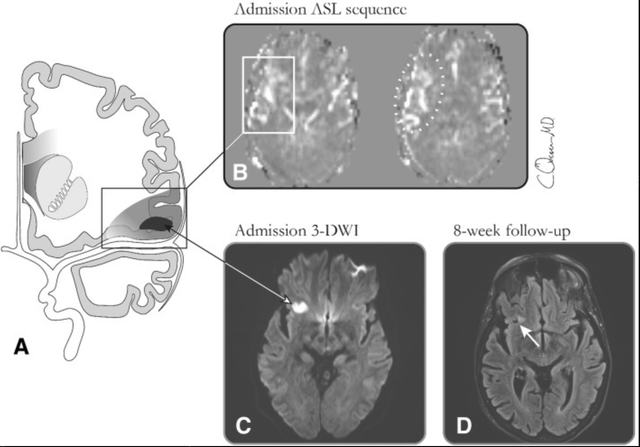

In [47]:
response = requests.get(image_question1["image_url"])
response.raise_for_status()
img = PILImage.open(io.BytesIO(response.content))
display(img)

In [48]:
input_data = {
    "model": "/opt/ml/model",
    "messages": [
        {"role": "system", "content": system_prompt},
        {
            "role": "user",
            "content": [
                {"type": "text", "text": image_question1["question"]},
                {"type": "image_url", "image_url": {"url": image_question1["image_url"]}}
            ]
        }
    ],
    "max_tokens": 2048,
    "temperature": 0.15,
}

result = invoke_realtime_endpoint(input_data)
output_content = result['choices'][0]['message']['content']
print(output_content)

### Analysis of Panel D

To determine what panel D illustrates, let's analyze the provided images and the context of each panel.

#### Panel Descriptions

- **Panel A**: This is a schematic diagram of the brain highlighting a specific region, likely indicating the area of interest for the subsequent imaging panels.
- **Panel B**: Labeled "Admission ASL sequence," this panel shows arterial spin labeling (ASL) images taken at the time of admission. ASL is a non-invasive MRI technique used to measure brain perfusion.
- **Panel C**: Labeled "Admission 3-DWI," this panel shows diffusion-weighted imaging (DWI) taken at the time of admission. DWI is used to detect acute ischemic stroke by measuring the diffusion of water molecules in the brain.
- **Panel D**: This panel is labeled "8-week follow-up" and shows an MRI image taken eight weeks after the initial admission.

#### Interpretation of Panel D

- **Infarct Core (Option A)**: The infarct core refers to the central area of dead tissue res

#### Image + Text Inference (Offline)

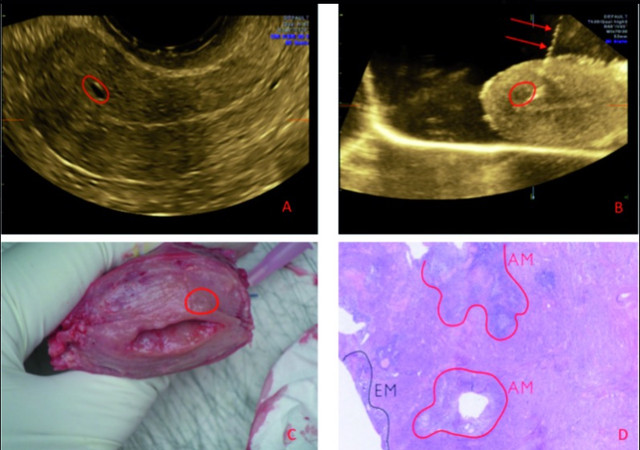

In [50]:
response = requests.get(image_question2["image_url"])
response.raise_for_status()
img = PILImage.open(io.BytesIO(response.content))
display(img)

In [51]:
image_base64 = base64.b64encode(response.content).decode("utf-8")
data_url = f"data:image/jpeg;base64,{image_base64}"

In [52]:
input_data = {
    "model": "/opt/ml/model",
    "messages": [
        {"role": "system", "content": system_prompt},
        {
            "role": "user",
            "content": [
                {"type": "text", "text": image_question2["question"]},
                {"type": "image_url", "image_url": {"url": data_url}}
            ]
        }
    ],
    "max_tokens": 2048,
    "temperature": 0.15,
}

result = invoke_realtime_endpoint(input_data)
output_content = result['choices'][0]['message']['content']
print(output_content)

### Analysis of Image D

**Visual Characteristics**
- Image D appears to be a histological section viewed under a microscope.
- The image shows glandular structures stained with hematoxylin and eosin (H&E), which is a common staining technique in histology.
- The glands are labeled with "AM" and "EM," and there are clear luminal spaces within the glands.

**Comparison with Options**
- **A: Normal uterus tissue**: Normal uterine tissue would typically show regular, well-organized glandular structures and stroma. While Image D shows glandular structures, the labeling suggests a specific focus on certain areas, which might not be typical of normal tissue.
- **B: The needle-marked zone of the uterus**: This option is less likely as needle marks would typically show tissue disruption or foreign body reaction, which is not evident in Image D.
- **C: The microcystic glands of the uterus**: This is a plausible option. Microcystic glands are small, cyst-like structures within the uterine tissue

### 3.1 Real-time inference response as a stream via Amazon SageMaker Endpoint

In [54]:
def invoke_streaming_endpoint(record):
    try:
        response = sm_runtime.invoke_endpoint_with_response_stream(
            EndpointName=model_name,
            Body=json.dumps(record),
            ContentType="application/json",
            Accept="text/event-stream"
        )

        for event in response["Body"]:
            if "PayloadPart" in event:
                chunk = event["PayloadPart"]["Bytes"].decode("utf-8")
                if chunk.startswith("data:"):
                    try:
                        data = json.loads(chunk[5:].strip())
                        if "choices" in data and len(data["choices"]) > 0:
                            choice = data["choices"][0]
                            if "text" in choice:
                                yield choice["text"]
                            elif "delta" in choice and "content" in choice["delta"]:
                                yield choice["delta"]["content"]

                    except json.JSONDecodeError:
                        continue 
            elif "ModelStreamError" in event:
                error = event["ModelStreamError"]
                yield f"\nStream error: {error['Message']} (Error code: {error['ErrorCode']})"
                break
            elif "InternalStreamFailure" in event:
                failure = event["InternalStreamFailure"]
                yield f"\nInternal stream failure: {failure['Message']}"
                break
    except Exception as e:
        yield f"\nAn error occurred during streaming: {str(e)}"

#### Chat Completion

In [55]:
payload = {
    "model": "/opt/ml/model",
    "messages": [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": prompt1}
    ],
    "max_tokens": 2048,
    "temperature": 0.15,
    "stream": True
}

for chunk in invoke_streaming_endpoint(payload):
    print(chunk, end="", flush=True)

### Immediate Steps to Take

**Monitor Your Symptoms:**
- Use a thermometer to check your temperature. A fever is typically considered to be a temperature above 100.4°F (38°C).
- Note the severity of your body aches and any other accompanying symptoms such as headache, sore throat, or fatigue.

**Stay Hydrated:**
- Drink plenty of fluids, such as water, clear broths, and electrolyte-replacement beverages.
- Avoid alcohol and caffeine, as they can contribute to dehydration.

**Rest:**
- Get plenty of rest to help your body fight off the infection.
- Avoid strenuous activities until your symptoms improve.

**Over-the-Counter Medications:**
- Consider taking over-the-counter medications such as acetaminophen (Tylenol) or ibuprofen (Advil, Motrin) to reduce fever and relieve body aches. Follow the dosage instructions on the package.
- Avoid giving aspirin to children under 18 due to the risk of Reye's syndrome.

### When to Seek Medical Attention

**Severe Symptoms:**
- If your fever is ve

#### Text Completion

In [56]:
payload = {
    "model": "/opt/ml/model",
    "prompt": prompt2,
    "max_tokens": 2048,
    "temperature": 0.15,
    "stream": True
}

for chunk in invoke_streaming_endpoint(payload):
    print(chunk, end="", flush=True)

F: Trimethoprim-sulfamethoxazole

1. **Identify the condition**: The patient presents with dysuria, which is a common symptom of a urinary tract infection (UTI). Given her pregnancy, it is crucial to consider the safety of the treatment options for both the mother and the fetus.

2. **Evaluate the options**:
   - **Ampicillin**: Generally safe in pregnancy but has a high resistance rate for UTIs.
   - **Ceftriaxone**: Safe in pregnancy and effective against UTIs, but used for more severe infections.
   - **Ciprofloxacin**: A fluoroquinolone, which is contraindicated in pregnancy due to adverse effects on the developing fetus.
   - **Doxycycline**: A tetracycline, which is contraindicated in pregnancy due to adverse effects on the developing fetus.
   - **Nitrofurantoin**: Safe in pregnancy and first-line treatment for uncomplicated UTIs.
   - **Trimethoprim-sulfamethoxazole**: Generally avoided in the first trimester due to potential folate antagonism, but can be used in the second and

#### Image + Text Inference (Online)

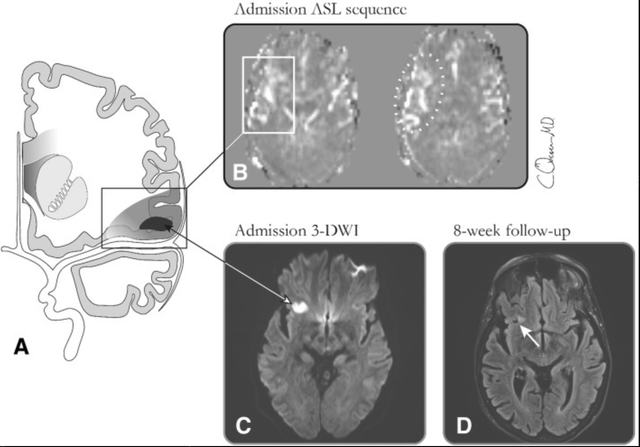

In [57]:
response = requests.get(image_question1["image_url"])
response.raise_for_status()
img = PILImage.open(io.BytesIO(response.content))
display(img)

In [58]:
payload = {
    "model": "/opt/ml/model",
    "messages": [
        {"role": "system", "content": system_prompt},
        {
            "role": "user",
            "content": [
                {"type": "text", "text": image_question1["question"]},
                {"type": "image_url", "image_url": {"url": image_question1["image_url"]}}
            ]
        }
    ],
    "max_tokens": 2048,
    "temperature": 0.15,
    "stream": True
}

for chunk in invoke_streaming_endpoint(payload):
    print(chunk, end="", flush=True)

 Analysis of Panel D

To determine what panel D illustrates, let's analyze the provided images and the context of each panel.

#### Panel Descriptions

- **Panel A**: This is a diagram of the brain highlighting a specific region, likely indicating the area of interest for the subsequent imaging panels.
- **Panel B**: Labeled "Admission ASL sequence," this panel shows arterial spin labeling (ASL) images taken at the time of admission. ASL is a non-invasive MRI technique used to measure brain perfusion.
- **Panel C**: Labeled "Admission 3-DWI," this panel shows diffusion-weighted imaging (DWI) taken at the time of admission. DWI is used to detect areas of acute ischemia (infarction) in the brain.
- **Panel D**: This panel is labeled "8-week follow-up" and shows an MRI image taken eight weeks after the initial admission.

#### Interpretation of Panel D

- **Infarct Core (Option A)**: The infarct core refers to the central area of dead tissue resulting from an ischemic stroke. This is typi

#### Image + Text Inference (Offline)

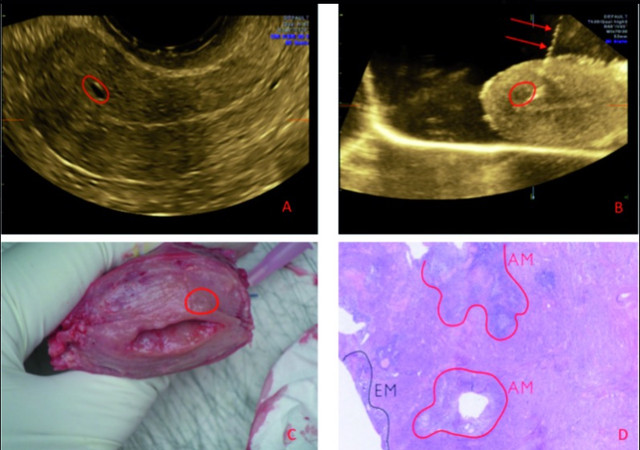

In [59]:
response = requests.get(image_question2["image_url"])
response.raise_for_status()
img = PILImage.open(io.BytesIO(response.content))
display(img)

In [60]:
image_base64 = base64.b64encode(response.content).decode("utf-8")
data_url = f"data:image/jpeg;base64,{image_base64}"

In [61]:
payload = {
    "model": "/opt/ml/model",
    "messages": [
        {"role": "system", "content": system_prompt},
        {
            "role": "user",
            "content": [
                {"type": "text", "text": image_question2["question"]},
                {"type": "image_url", "image_url": {"url": data_url}}
            ]
        }
    ],
    "max_tokens": 2048,
    "temperature": 0.15,
    "stream": True
}

for chunk in invoke_streaming_endpoint(payload):
    print(chunk, end="", flush=True)

 Analysis of Image D

**Visual Characteristics**
- Image D appears to be a histological section viewed under a microscope.
- The image shows glandular structures stained with hematoxylin and eosin (H&E), which is a common staining technique in histology.
- The glands are labeled with "AM" and "EM," and there are circular structures within the glands.

**Interpretation of Labels**
- "AM" likely stands for adenomyosis or adenomyotic tissue.
- "EM" likely stands for endometrial tissue.
- The circular structures within the glands could represent microcysts or small glandular formations.

**Comparison with Options**
- **A: Normal uterus tissue** - Normal uterine tissue typically does not show the glandular structures with microcysts as seen in Image D.
- **B: The needle-marked zone of the uterus** - This would not show glandular structures but rather tissue damage or marking from a needle.
- **C: The microcystic glands of the uterus** - This matches the visual characteristics of Image D, wh

Now that you have successfully performed a real-time inference, you do not need the endpoint any more. You can terminate the endpoint to avoid being charged.

In [ ]:
model.sagemaker_session.delete_endpoint(model_name)
model.sagemaker_session.delete_endpoint_config(model_name)

## 4. Batch inference

In [11]:
validation_json_file_name1 = "input1.json"
validation_json_file_name2 = "input2.json"
validation_json_file_name3 = "input3.json"
validation_input_json_path = f"s3://{s3_bucket}/{model_name}/validation-input/"
validation_output_json_path = f"s3://{s3_bucket}/{model_name}/validation-output/"


def write_and_upload_to_s3(input_data, file_name):
    s3_client.put_object(
        Bucket=s3_bucket,
        Key=f"{model_name}/validation-input/{file_name}",
        Body=(bytes(input_data.encode("UTF-8"))),
    )

In [12]:
# payload for text-only prompts
payload1 = json.dumps({
    "model": "/opt/ml/model",
    "prompt": prompts,
    "max_tokens": 2048,
    "temperature": 0.15,
})



# payload for image + text
response1 = requests.get(image_question1["image_url"])
response1.raise_for_status()
image_base64 = base64.b64encode(response1.content).decode("utf-8")
data_url = f"data:image/jpeg;base64,{image_base64}"

payload2 = json.dumps({
    "model": "/opt/ml/model",
    "messages": [
        {"role": "system", "content": system_prompt},
        {
            "role": "user",
            "content": [
                {"type": "text", "text": image_question1["question"]},
                {"type": "image_url", "image_url": {"url": data_url}}
            ]
        }
    ],
    "max_tokens": 2048,
    "temperature": 0.15,
})



response2 = requests.get(image_question2["image_url"])
response2.raise_for_status()
image_base64 = base64.b64encode(response2.content).decode("utf-8")
data_url = f"data:image/jpeg;base64,{image_base64}"

payload3 = json.dumps({
    "model": "/opt/ml/model",
    "messages": [
        {"role": "system", "content": system_prompt},
        {
            "role": "user",
            "content": [
                {"type": "text", "text": image_question2["question"]},
                {"type": "image_url", "image_url": {"url": data_url}}
            ]
        }
    ],
    "max_tokens": 2048,
    "temperature": 0.15,
})


# Upload
write_and_upload_to_s3(payload1, validation_json_file_name1)
write_and_upload_to_s3(payload2, validation_json_file_name2)
write_and_upload_to_s3(payload3, validation_json_file_name3)

In [ ]:
transformer = model.transformer(
    instance_count=1,
    instance_type=batch_transform_inference_instance_type,
    accept="application/json",
    output_path=validation_output_json_path,
)
transformer.transform(validation_input_json_path, content_type="application/json")
transformer.wait()

In [15]:
from urllib.parse import urlparse

def retrieve_json_output_from_s3(validation_file_name):

    parsed_url = urlparse(transformer.output_path)
    file_key = f"{parsed_url.path[1:]}{validation_file_name}.out"
    response = s3_client.get_object(Bucket=s3_bucket, Key=file_key)
    result = json.loads(response["Body"].read().decode("utf-8"))
    
    for idx, choice in enumerate(result.get("choices", [])):
        if "text" in choice:
            content = choice["text"]
        elif "message" in choice and "content" in choice["message"]:
            content = choice["message"]["content"]
        else:
            content = "[No text or message content found]"

        print(f"Response {idx + 1}:\n{content}\n{'=' * 75}")

#### Text Inference

In [16]:
retrieve_json_output_from_s3(validation_json_file_name1)

Response 1:
 The kidneys are vital organs that play a crucial role in filtering waste products and excess fluids from the blood, maintaining electrolyte balance, and regulating blood pressure. Maintaining good kidney health is essential for overall well-being. Here are some tips to help you keep your kidneys healthy:

1. Stay Hydrated: Drinking plenty of water helps the kidneys function properly by flushing out toxins and waste products. Aim for at least 8 glasses of water a day, but adjust based on your activity level and climate.

2. Eat a Balanced Diet: A diet rich in fruits, vegetables, whole grains, and lean proteins can support kidney health. Limit your intake of processed foods, red meat, and foods high in sodium and sugar.

3. Control Blood Pressure and Blood Sugar: High blood pressure and diabetes are leading causes of kidney disease. Regularly monitor your blood pressure and blood sugar levels, and follow your healthcare provider's recommendations for managing these condition

#### Image + Text Inference (Offline)

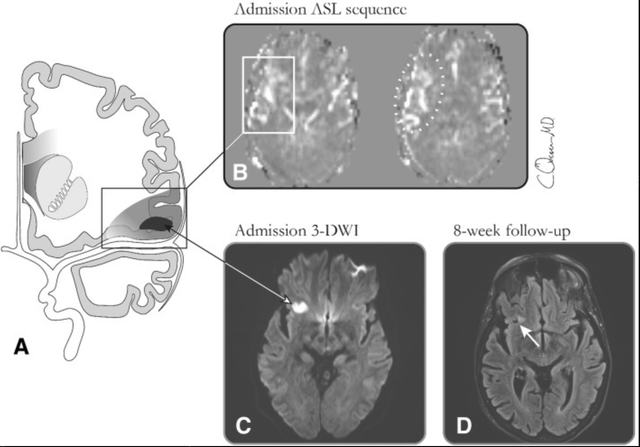

Response 1:
### Analysis of Panel D

To determine what panel D illustrates, let's analyze the provided images and the context of each panel.

#### Panel Descriptions

- **Panel A**: This is a schematic diagram of the brain highlighting a specific region, likely indicating the area of interest for the subsequent imaging panels.
- **Panel B**: Labeled "Admission ASL sequence," this panel shows arterial spin labeling (ASL) images taken at the time of admission. ASL is a non-invasive MRI technique used to measure brain perfusion.
- **Panel C**: Labeled "Admission 3-DWI," this panel shows diffusion-weighted imaging (DWI) taken at the time of admission. DWI is used to detect areas of acute ischemia (infarction) in the brain.
- **Panel D**: This panel is labeled "8-week follow-up" and shows an MRI image taken 8 weeks after the initial admission.

#### Interpretation of Panel D

- **Infarct Core (Option A)**: The infarct core refers to the central area of dead tissue resulting from an ischemic

In [17]:
img = PILImage.open(io.BytesIO(response1.content))
display(img)
retrieve_json_output_from_s3(validation_json_file_name2)

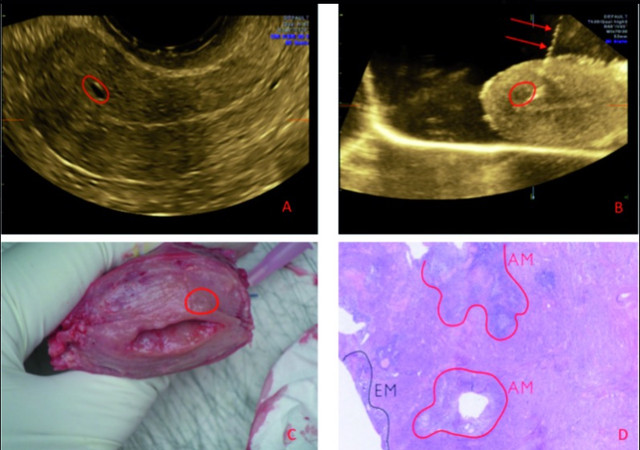

Response 1:
### Analysis of Image D

**Visual Characteristics**
- Image D appears to be a histological slide, which is a thin slice of tissue viewed under a microscope and stained to highlight different structures.
- The image shows glandular structures within a stromal background.
- The glands are outlined in red and labeled as "AM."
- The surrounding tissue is labeled as "EM."

**Comparison with Options**
- **A: Normal uterus tissue** - Normal uterine tissue would typically show regular glandular structures and stroma, but without specific markings like "AM" and "EM," it is less likely to be the correct answer.
- **B: The needle-marked zone of the uterus** - This would not typically show glandular structures under a microscope. Needle marks are usually seen in gross pathology and not in histological slides.
- **C: The microcystic glands of the uterus** - Microcystic glands are small, cyst-like structures within the uterine tissue. The glands in Image D are outlined and labeled, sugge

In [18]:
img = PILImage.open(io.BytesIO(response2.content))
display(img)
retrieve_json_output_from_s3(validation_json_file_name3)

Congratulations! You just verified that the batch transform job is working as expected. Since the model is not required, you can delete it. Note that you are deleting the deployable model. Not the model package.

In [ ]:
model.delete_model()

### Unsubscribe to the listing (optional)

If you would like to unsubscribe to the model package, follow these steps. Before you cancel the subscription, ensure that you do not have any [deployable model](https://console.aws.amazon.com/sagemaker/home#/models) created from the model package or using the algorithm. Note - You can find this information by looking at the container name associated with the model. 

**Steps to unsubscribe to product from AWS Marketplace**:
1. Navigate to __Machine Learning__ tab on [__Your Software subscriptions page__](https://aws.amazon.com/marketplace/ai/library?productType=ml&ref_=mlmp_gitdemo_indust)
2. Locate the listing that you want to cancel the subscription for, and then choose __Cancel Subscription__  to cancel the subscription.

